In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
np.random.seed(0)  # For reproducibility
class Env:
    def __init__(self,num_swimmer):
        self.num_swimmer = num_swimmer
        self.v_max=1
        self.initial_angle=np.zeros(num_swimmer)
        self.initial_orientation=np.zeros((num_swimmer,2))
        self.speed = self.v_max
        self.initial_position =np.zeros((num_swimmer,2))
        self.box_x = 40
        self.box_y = 20
        self.box_z = 10
        self.time = 0
        self.vision_distance=5
        self.inner_distance=1
        self.position=[]
        self.orientation=[]
        self.phi=[]
        self.theta=[]
        self.momentum=[]
        self.angular_momentum=[]
        self.blind_phi= np.pi / 36
        self.blind_theta= np.pi / 12
        self.t_f=100
        self.dt=0.1
        self.noise_theta=0.01
        self.noise_phi=0.01
        self.track_index=0
    def reset(self,goal):
        self.goal= goal
        self.velocity = np.zeros(self.num_swimmer)
        self.initial_phi= np.random.uniform(-np.pi,  np.pi, self.num_swimmer)
        self.initial_theta= np.random.uniform(np.pi/2-np.pi/12,  np.pi/2+np.pi/12, self.num_swimmer)
        self.initial_orientation = np.column_stack((np.sin(self.initial_theta)*np.cos(self.initial_phi), np.sin(self.initial_theta)*np.sin(self.initial_phi),np.cos(self.initial_theta)))
        self.initial_position = np.column_stack((np.array([self.box_x,self.box_y])[None,:]*np.random.uniform(0, 1, (self.num_swimmer, 2)),\
                                                 self.box_z*np.random.uniform(0.4, 0.6, (self.num_swimmer, 1))))
        self.time = 0
        self.position.append(self.initial_position)
        self.orientation.append(self.initial_orientation)
        self.theta.append(self.initial_theta)
        self.phi.append(self.initial_phi)
        Average_momentum, Average_angular_momentum = self._order_parameters(self.initial_position, self.initial_orientation)
        self.momentum.append(Average_momentum)
        self.angular_momentum.append(Average_angular_momentum)
    def _inner_variable(self,position,orientation,phi,theta):
        Inner_position=position[None,:]- position[:,None]#0th axis:relative to Swimmer,1st axis: observed swimmer
        Inner_distance = np.linalg.norm(Inner_position, axis=2)
        Inner_phi= np.arctan2(Inner_position[:,:,1], Inner_position[:,:,0])-np.arctan2(orientation[:,1], orientation[:,0])[:,None]
        r_xy=np.linalg.norm(Inner_position[:,:,[0,1]], axis=2)
        r_orientation = np.linalg.norm(orientation[:,[0,1]], axis=1)
        Inner_theta = np.arctan2(r_xy,Inner_position[:,:,2]) -np.arctan2(r_orientation,orientation[:,2])[:,None]
        boolean_vision = (Inner_distance !=0)*(Inner_distance < self.vision_distance)*(np.abs(Inner_theta) < np.pi-self.blind_theta/2)*(np.abs(Inner_phi) < np.pi-self.blind_phi/2)  #Bool_vision_include itself
        Distance_to_wall=np.zeros((self.num_swimmer,6))
        Distance_to_wall[:,0]=position[:,0] #left wall
        Distance_to_wall[:,1]=self.box_x-position[:,0]# right wall
        Distance_to_wall[:,2]=position[:,1]#up wall
        Distance_to_wall[:,3]=self.box_y-position[:,1]# down wall
        Distance_to_wall[:,4]=position[:,2]# bottom wall
        Distance_to_wall[:,5]=self.box_z-position[:,2]# top wall
        boolean_wall =(Distance_to_wall < self.inner_distance)
        return boolean_vision,boolean_wall
    def _order_parameters(self,position,orientation):
        CM= np.mean(position,axis=0)
        relative_position = position - CM[None,:]
        
        Average_momentum = np.linalg.norm(np.mean(orientation,axis=0))
       
        Average_angular_momentum =np.mean( np.cross(relative_position - CM[None,:], orientation),axis=0)/np.max(np.linalg.norm(relative_position,axis=1))
        return Average_momentum, Average_angular_momentum
   

    def step(self):
        cur_theta = self.theta[self.time].copy()
        cur_phi = self.phi[self.time].copy()
        cur_position = self.position[self.time]
        cur_orientation = self.orientation[self.time]

        boolean_vision,boolean_wall  = self._inner_variable(cur_position, cur_orientation, cur_phi,cur_theta)
        num_observed = boolean_vision.sum(axis=1)
        new_theta= cur_theta*(num_observed==0)+self.noise_theta*np.random.randn(self.num_swimmer)
        new_theta+= np.sum(cur_theta[None,:]*boolean_vision,axis=1)/np.maximum(num_observed,1)

        
        new_phi=  cur_phi*(num_observed==0)+self.noise_phi*np.random.randn(self.num_swimmer) 
        new_phi+= np.sum(cur_phi[None,:]*boolean_vision,axis=1)/np.maximum(num_observed,1)
        ratio=0.3
        new_phi[boolean_wall[:,0]]   = ratio*new_phi[boolean_wall[:,0]]+ (1-ratio)*0 # left wall
        new_phi[boolean_wall[:,1]]   = ratio*new_phi[boolean_wall[:,1]]+ (1-ratio)*np.pi # right wall
        new_phi[boolean_wall[:,2]]   = ratio*new_phi[boolean_wall[:,2]]+ (1-ratio)*np.pi/2 # up wall
        new_phi[boolean_wall[:,3]]   = ratio*new_phi[boolean_wall[:,3]]+ (1-ratio)*3*np.pi/2 # down wall
        new_theta[boolean_wall[:,4]] = ratio*new_theta[boolean_wall[:,4]] + (1-ratio)*(np.pi/2-0.01) # bottom wall
        new_theta[boolean_wall[:,5]] = ratio*new_theta[boolean_wall[:,5]] + (1-ratio)*(np.pi/2+0.01) # top wall
        new_orientation = np.column_stack((np.sin(new_theta)*np.cos(new_phi), np.sin(new_theta)*np.sin(new_phi),np.cos(new_theta)))

        new_position = cur_position + self.speed * new_orientation * self.dt
        new_position= np.clip(new_position, 0, [self.box_x, self.box_y, self.box_z])
        self.theta.append(new_theta)
        self.phi.append(new_phi)
        self.orientation.append(new_orientation)
        self.position.append(new_position)

        self.time += 1
        Average_momentum, Average_angular_momentum = self._order_parameters(new_position, new_orientation)
        self.momentum.append(Average_momentum)
        self.angular_momentum.append(Average_angular_momentum)
        if self.time >= self.t_f:
            done = True
        else:
            done = False
        
        return done
    def _plot(self,ax,t):
        ax.view_init(elev=70, azim=-90, roll=0)
        ax.set_xlim(0, self.box_x)
        ax.set_ylim(0, self.box_y)
        ax.set_zlim(0, self.box_z)
        ax.set_aspect('equal')
        ax.quiver(self.position[t][:, 0], self.position[t][:, 1], self.position[t][:, 2],
                   self.orientation[t][:, 0], self.orientation[t][:, 1],self.orientation[t][:, 2],
                 color='blue', length=2, normalize=True, arrow_length_ratio=0.5) 
        ax.set_title(f'Timestep:{t}')
    def render(self):
        fig = plt.figure(figsize=(10, 8)) # 10 inches wide, 8 inches tall
        
        # Add a 3D axes to the figure
        ax = fig.add_subplot(111, projection='3d')
        def animate(i):
            ax.clear()
            self._plot(ax,i)
        ani = FuncAnimation(fig, animate, frames=self.time+1,
                            interval=10, repeat=False)
        plt.close()
        # embedding for the video 
        html = display.HTML(ani.to_jshtml()) 
        
        # draw the animation 
        display.display(html) 
        plt.close() 
        return ani
num_swimmer=10
env= Env(num_swimmer)
env.reset("swarm")
done=False
while not done:
    done = env.step()
ani=env.render()
# Save the animation as an HTML file
ani.save('vicsek.mp4', writer='ffmpeg')


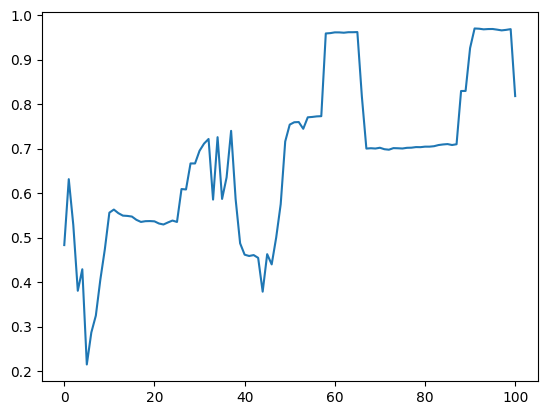

In [77]:
plt.plot(env.momentum, label='Average Momentum')